Not a lot of code in this chapter. The following are some topics I've decided to create a program for.

Single Bit ADC & DAC - Normal Delta Modulation + CVSD (Continously Variable Step Delta)

In [156]:
import numpy as np
import scipy as sp
import scipy.io
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os

In [157]:
filename = 'emodat-Copy1.mat'
file = scipy.io.loadmat(filename)
n = 100
x = file['data']
x = x[0]
x = x[0:n]
time = np.arange(0,n,1)
deltmod = np.zeros(n)
cvsdmod = np.zeros(n)
logic_state = np.zeros(n)

In [160]:
def one_bit_converter(signal,ss):
    running_voltage = 0
    for i in range(0,n):
        if running_voltage < signal[i]:
            running_voltage = running_voltage + ss
            deltmod[i] = running_voltage
            logic_state[i] = 1
        else:
            running_voltage = running_voltage - ss
            deltmod[i] = running_voltage
            logic_state[i] = 0
    return(deltmod)

def cvsd(signal,increment): #Need to make a de-increment mlethod for this too lazy will do it in future
    running_voltage = 0
    step_size = 1.5
    all_zeros = np.array([0,0,0,0])
    all_ones = np.array([1,1,1,1])
    for i in range(0,n):
        four_bit_shift_register = logic_state[i-4:i]
        if np.array_equal(four_bit_shift_register,all_zeros) or np.array_equal(four_bit_shift_register,all_ones):
            step_size = step_size + increment
        if running_voltage < signal[i]:
            running_voltage = running_voltage + step_size
            cvsdmod[i] = running_voltage
        else:
            running_voltage = running_voltage - step_size
            cvsdmod[i] = running_voltage
    return(cvsdmod)

def hausen1(step_size):
    hausen_x = list(zip(time,x))
    hausen_deltmod = list(zip(time,one_bit_converter(x,step_size)))
    hausen = scipy.spatial.distance.directed_hausdorff(hausen_x,hausen_deltmod)
    return hausen[0]

def hausen2(incr):
    hausen_x = list(zip(time,x))
    hausen_cvsdmod = list(zip(time,cvsd(x,incr)))
    hausen = scipy.spatial.distance.directed_hausdorff(hausen_x,hausen_cvsdmod)
    return hausen[0]


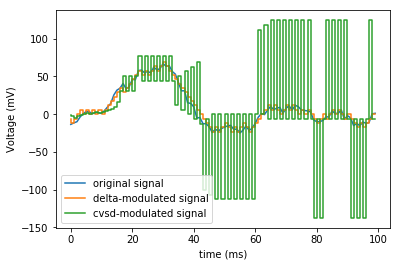

Step Size: 5.76654052734375
Hausendorff Distance: 3.1022211105365494
Increment size: 6.1614990234375
Hausendorff Distance: 4.018494949959781


In [161]:
r1 = minimize(hausen1,5,method = 'Nelder-Mead')
r2 = minimize(hausen2,10,method = 'Nelder-Mead')

one_bit_converter(x,r1.x)
cvsd(x,r2.x)
plt.plot(time,x, label = 'original signal')
plt.step(time,deltmod, label = 'delta-modulated signal')
plt.step(time,cvsdmod, label = 'cvsd-modulated signal')
plt.xlabel('time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend(loc='best')
plt.show()
print("Step Size: {0}\nHausendorff Distance: {1}" .format(float(r1.x),hausen(r1.x)))
print("Increment size: {0}\nHausendorff Distance: {1}" .format(float(r2.x),hausen(r2.x)))

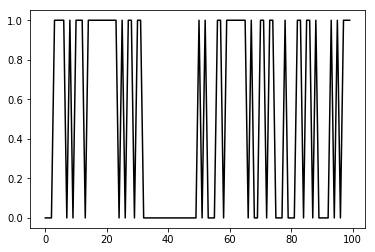

In [127]:
plt.plot(logic_state, color = 'k')
#slew rate periods shown as horizontalsegments 